<a href="https://colab.research.google.com/github/SriSathwik1905/LLM-Hackathon/blob/main/Models/Round_1_Take_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re
import string

In [ ]:
# Ensure required NLTK resources are available
nltk.download('stopwords')

# Load dataset
df = pd.read_excel(r'Hackathon_Round_1.xlsx', engine='openpyxl')

# Select relevant columns
df = df[['Text', 'subtask_a', 'subtask_b']]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)


In [ ]:
# Apply preprocessing
df['Cleaned_Text'] = df['Text'].apply(preprocess_text)


In [ ]:
# First-Level Classification (COVID vs Non-COVID)
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned_Text'], df['subtask_a'], test_size=0.2, random_state=42)

In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
# Logistic Regression with GridSearchCV for fine-tuning
log_reg_model = LogisticRegression(max_iter=500)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

First-Level Classification (COVID vs Non-COVID):
              precision    recall  f1-score   support

        CORO       1.00      0.99      0.99      9381
        NOCO       0.98      1.00      0.99      4948

    accuracy                           0.99     14329
   macro avg       0.99      0.99      0.99     14329
weighted avg       0.99      0.99      0.99     14329



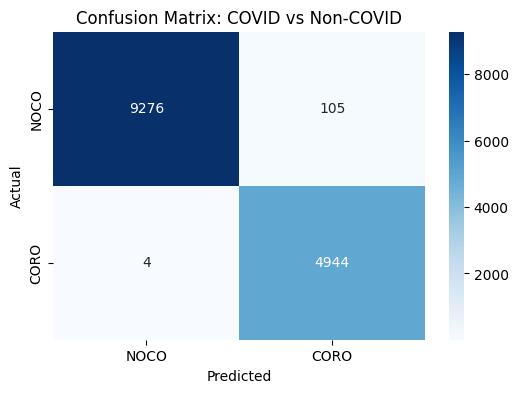

In [ ]:
# Best model
best_log_reg_model = grid_search.best_estimator_
y_pred = best_log_reg_model.predict(X_test_tfidf)

print("First-Level Classification (COVID vs Non-COVID):")
print(classification_report(y_test, y_pred))
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["NOCO", "CORO"], yticklabels=["NOCO", "CORO"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: COVID vs Non-COVID")
plt.show()


Second-Level Classification (CORO Emotional vs Non-Emotional):
              precision    recall  f1-score   support

        COEM       0.89      0.88      0.88      4487
        CONE       0.90      0.90      0.90      4945

    accuracy                           0.89      9432
   macro avg       0.89      0.89      0.89      9432
weighted avg       0.89      0.89      0.89      9432



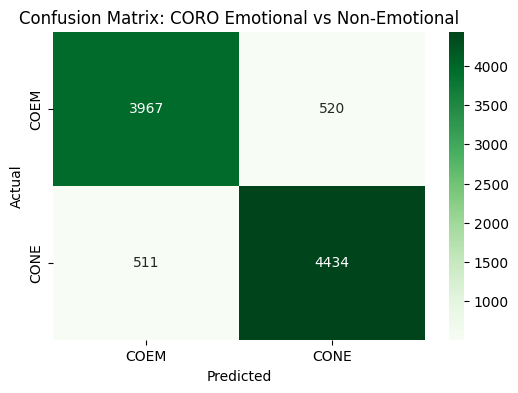


Second-Level Classification (NOCO Emotional vs Non-Emotional):
              precision    recall  f1-score   support

        NOEM       0.93      0.73      0.81      1959
        NONE       0.84      0.96      0.90      2938

    accuracy                           0.87      4897
   macro avg       0.88      0.84      0.86      4897
weighted avg       0.87      0.87      0.86      4897



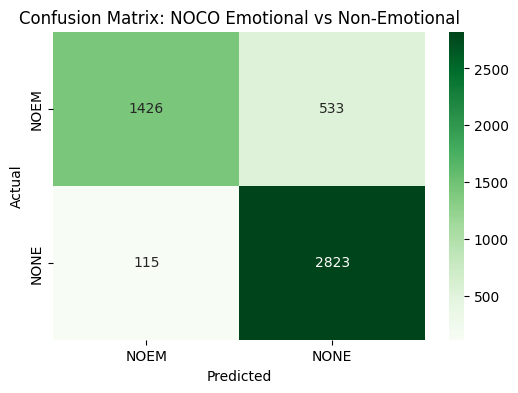

In [ ]:
# Second-Level Classification Models
nb_models = {}
for label in ["CORO", "NOCO"]:
    df_subset = df[df['subtask_a'] == label]
    X_train, X_test, y_train, y_test = train_test_split(df_subset['Cleaned_Text'], df_subset['subtask_b'], test_size=0.2, random_state=42)

    # TF-IDF Vectorization
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Multinomial Naive Bayes with GridSearchCV for fine-tuning
    nb_model = MultinomialNB()
    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
    grid_search = GridSearchCV(nb_model, param_grid, cv=5)
    grid_search.fit(X_train_tfidf, y_train)
# Best model
    best_nb_model = grid_search.best_estimator_
    nb_models[label] = best_nb_model

    y_pred = best_nb_model.predict(X_test_tfidf)

    print(f"\nSecond-Level Classification ({label} Emotional vs Non-Emotional):")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {label} Emotional vs Non-Emotional")
    plt.show()